# Find the DosR binding sites in bacterial genomes, and associated gene regions

- I recommend using pypy for this, as some of these analyses are computationally expensive.
- We start by reading in the data, and running a Gibbs sampler with varying ks to get an idea of how big the motifs are.
- next, we zero in on our best guess of k, which just happens to be 20 (I cheated a little and checked out Park et al. 2003).
- Once we have our motif matrix, we find a consensus string.
- And last, we look for start codons and stop codons downstream from the promotors to take a stab at finding the associated genes. 

## Import and parse the data:

 By default, the parseFile.parse() function assumes a newline delimited file with a header row of parameters. This can be changed, see the docstring for parseFile() for more info.

In [2]:
import sys, parseFile, gibbsSamplerScript, math, medianString

#Your file here:
file = "DosR.txt"
data = parseFile.parse(file)
params, dna = data
k, t = params

## Find an estimate of motif length:

 This runs a quick and dirty gibbs sampler on ks between 10 and 25, and print the best kmer for each.  By default, it uses hamming distance from consensus strings as its minimization function, but it can also use entropy. See gibbsSampler.py for info.

In [3]:



motifs = {'bestK' : 0, 'bestKScore': math.inf, 'bestMotif' : ''}
for i in range(15, 25):
    answer = gibbsSamplerScript.runGibbsSampler(dna=dna, k=i, t=t, reps=30, searchLength=2000)
    answerDict = {}
    answerDict["score"] = answer[0]
    answerDict["motifs"] = answer[1]
    answerDict["ratio"] = answerDict["score"]/i
    #answerDict["consensus"] = medianString.medianString(answerDict["motifs"], i)
    if answerDict["ratio"] < motifs["bestKScore"]:
        motifs["bestK"] = i
        motifs["bestKScore"] = answerDict["ratio"]
        #motifs["bestMotif"] = answerDict["consensus"]
    motifs[i] = answerDict
    ratio=answerDict["ratio"]
    #consensus = answerDict["consensus"]
    print(f"Per-base score for k = {i} is: {ratio}")

print("bestK:      ", motifs['bestK'])
print("bestKScore: ", motifs['bestKScore'])
#print("Best consensus motif: ", motifs["bestMotif"])
print("Printing answers:")
print(motifs)

GGGACTTCAGGCCCT GGGTCAAACGACCCT GGGACGTAAGTCCCT CGGGCTTCCAACCGT GTGACCGACGTCCCC AGGACCTTCGGCCCC GGGACTTCTGTCCCT GGGACTTTCGGCCCT GGGACCAACGCCCCT GGGACCGAAGTCCCC 35
Per-base score for k = 15 is: 2.3333333333333335
GGGACTTCAGGCCCTA GGGTCAAACGACCCTA GGGACGTAAGTCCCTA GTGGGCAGCCTCCATA GTGACCGACGTCCCCA AGGACCTTCGGCCCCA GGGACTTCTGTCCCTA GGGACTTTCGGCCCTG GGGACCAACGCCCCTG GGGACCGAAGTCCCCG 38
Per-base score for k = 16 is: 2.375
GGGACTTCAGGCCCTAT GGGTCAAACGACCCTAG GGGACGTAAGTCCCTAA TGGATTACCGACCGCAG GTGACCGACGTCCCCAG AGGACCTTCGGCCCCAC GGGACTTCTGTCCCTAG GGGACTTTCGGCCCTGT GGGACCAACGCCCCTGG GGGACCGAAGTCCCCGG 43
Per-base score for k = 17 is: 2.5294117647058822
GGGACTTCAGGCCCTATC GGGTCAAACGACCCTAGT GGGACGTAAGTCCCTAAC GCCGTCTCAGTACCCAGC GTGACCGACGTCCCCAGC AGGACCTTCGGCCCCACC GGGACTTCTGTCCCTAGC GGGACTTTCGGCCCTGTC GGGACCAACGCCCCTGGG GGGACCGAAGTCCCCGGG 46
Per-base score for k = 18 is: 2.5555555555555554
GGGACTTCAGGCCCTATCG GGGTCAAACGACCCTAGTG GGGACGTAAGTCCCTAACG CGGGCTTCCAACCGTGGCC GTGACCGACGTCCCCAGCC AGGAC

## Take a look at the relative score as a function of k

This should give us an idea of where the motifs start to diverge, i.e. the motif size.


/usr/local/Cellar/pypy3/7.3.6/libexec/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


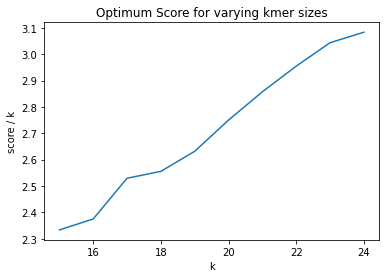

In [5]:
import matplotlib.pyplot as plt

x = [i for i in range(15, 25, 1)]
y = [motifs[i]['ratio'] for i in range(15, 25, 1)]

plt.plot(x, y)
plt.title("Optimum Score for varying kmer sizes")
plt.xlabel("k")
plt.ylabel("score / k")
plt.show()

## Zero in on 20-mer motifs, and find the consensus motif

Ok, it looks like k near 20 is a good guess (I'm either explicitly incorporating my prior beleifs here like a good Bayesian or cheating by looking at Park et al. You can decide ;). Let's run a longer search on the data for a 20-mer motif matrix. Hopefully this will give us a good estimate of the DosR promotor sites.

(The gibbs Sampler algorithm is gonna lag for quite a while because we are doing 50 iterations of the inner loop, which iterates 2000 times. This is where pypy really comes in handy. Go grab a coffee.)

In [7]:
import consensus

score, motifMatrix = gibbsSamplerScript.runGibbsSampler(dna=dna, k=20, t=t, reps=50, searchLength=2000)
consensusString = consensus.consensus(motifMatrix)

print(f"The inferred motif matrix is:")
[print(line) for line in motifMatrix]
print(f"The consensus string is {consensusString} and the score is {score}")

CGGGACTTCAGGCCCTATCG CGGGTCAAACGACCCTAGTG CGGGACGTAAGTCCCTAACG CCGGGCTTCCAACCGTGGCC CGTGACCGACGTCCCCAGCC GAGGACCTTCGGCCCCACCC GGGGACTTCTGTCCCTAGCC TGGGACTTTCGGCCCTGTCC GGGGACCAACGCCCCTGGGA GGGGACCGAAGTCCCCGGGC 55
The inferred motif matrix is:
CGGGACTTCAGGCCCTATCG
CGGGTCAAACGACCCTAGTG
CGGGACGTAAGTCCCTAACG
CCGGGCTTCCAACCGTGGCC
CGTGACCGACGTCCCCAGCC
GAGGACCTTCGGCCCCACCC
GGGGACTTCTGTCCCTAGCC
TGGGACTTTCGGCCCTGTCC
GGGGACCAACGCCCCTGGGA
GGGGACCGAAGTCCCCGGGC
The consensus string is CGGGACCTACGTCCCTAGCC and the score is 55


## Find associated coding regions

Now that we have a good idea of the motif, we can find the index of the motif in each string. Then we can look downstream of the promoter site for a start codon and stop codon. We'll then take that to be an inferred coding region.

EDIT: Turns out these sequences probably don't have coding regions, they have been snipped out to make the earlier exercise easier. But if they DID, just imagine the possibilities! This code should work to find downstream coding regions, with a few assumptions.

In [18]:
import geneFinder
from importlib import reload
reload(geneFinder)
promoterIndices = [string.find(motifMatrix[i]) for i, string in enumerate(dna)]

genes = []
for index, seq in enumerate(dna):
    gene = geneFinder.search(seq, index=promoterIndices[index])
    genes.append(gene)
for i, gene in enumerate(genes):
    if len(gene) < 6:
        genes[i] = None
print("The inferred genes are:")
[print(gene) for gene in genes]

The inferred genes are:
ATGCATTATGACCAGCGAGCTGAGCCTGGTCGCCACTGGAAAGGGGAGCAACATC
None
None
None
None
ATGACGTGCAATGTACGCCATAGGGTGCGTGTTACGGCGATTACCTGA
ATGGGCTGGTCGGATCAAAGGCATCCGTTTCCATCGATTAGGAGGCATCAA
None
ATGTATCCGCCCCAGCGAAGGAGACGGCG
None


[None, None, None, None, None, None, None, None, None, None]